In [1]:
import fastai
from fastai.vision.all import *
from fastai.vision.gan import generate_noise
from fastdownload import FastDownload
import matplotlib.pyplot as plt
from models.GAN import Generator, Critic, GANLearner
from torchsummary import summary
from util.util import GANIntToFloatTensor

In [2]:
path = Path('./data')

In [3]:
Path.BASE_PATH = path

In [4]:
if not (path/'archive').exists():
    loader = FastDownload(base=path.name, module=fastai.data)
    loader.update('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/camel.npy')
    loader.download('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/camel.npy')

In [5]:
def get_quickdraw_tensors(path):
    files = get_files(path, extensions=['.npy'])
    i = 0
    
    for f in files:
        subject = torch.from_numpy(np.load(f))
        subject = subject.view(subject.shape[0], 1, 28, 28)
        
        if i == 0:
            x = subject
        else:
            x = torch.cat((x, subject))
        
        i += 1
    
    return x

In [6]:
generator = Generator(z_dim=100,
                      unflattened_shape=[64, 7, 7],
                      upsample_scale=[2, 2, 1, 1],
                      filters=[128, 64, 64, 1],
                      kernels=[5, 5, 5, 5],
                      strides=[1, 1, 1, 1],
                      batch_norm_mom=0.9,
                      dropout_prob=None
                     )

critic = Critic(input_shape=[1, 28, 28],
                filters=[64, 64, 128, 128],
                kernels=[5, 5, 5, 5],
                strides=[2, 2, 2, 1],
                batch_norm_mom=None,
                dropout_prob=0.4,
                w_sigmoid=True
               )

In [7]:
summary(critic, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 64, 14, 14]          1,664
|    └─LeakyReLU: 2-2                    [-1, 64, 14, 14]          --
|    └─Dropout2d: 2-3                    [-1, 64, 14, 14]          --
|    └─Conv2d: 2-4                       [-1, 64, 7, 7]            102,464
|    └─LeakyReLU: 2-5                    [-1, 64, 7, 7]            --
|    └─Dropout2d: 2-6                    [-1, 64, 7, 7]            --
|    └─Conv2d: 2-7                       [-1, 128, 4, 4]           204,928
|    └─LeakyReLU: 2-8                    [-1, 128, 4, 4]           --
|    └─Dropout2d: 2-9                    [-1, 128, 4, 4]           --
|    └─Conv2d: 2-10                      [-1, 128, 4, 4]           409,728
|    └─LeakyReLU: 2-11                   [-1, 128, 4, 4]           --
|    └─Dropout2d: 2-12                   [-1, 128, 4, 4]           

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 64, 14, 14]          1,664
|    └─LeakyReLU: 2-2                    [-1, 64, 14, 14]          --
|    └─Dropout2d: 2-3                    [-1, 64, 14, 14]          --
|    └─Conv2d: 2-4                       [-1, 64, 7, 7]            102,464
|    └─LeakyReLU: 2-5                    [-1, 64, 7, 7]            --
|    └─Dropout2d: 2-6                    [-1, 64, 7, 7]            --
|    └─Conv2d: 2-7                       [-1, 128, 4, 4]           204,928
|    └─LeakyReLU: 2-8                    [-1, 128, 4, 4]           --
|    └─Dropout2d: 2-9                    [-1, 128, 4, 4]           --
|    └─Conv2d: 2-10                      [-1, 128, 4, 4]           409,728
|    └─LeakyReLU: 2-11                   [-1, 128, 4, 4]           --
|    └─Dropout2d: 2-12                   [-1, 128, 4, 4]           

In [8]:
summary(generator, (100,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 28, 28]           --
|    └─Linear: 2-1                       [-1, 3136]                316,736
|    └─BatchNorm1d: 2-2                  [-1, 3136]                6,272
|    └─LeakyReLU: 2-3                    [-1, 3136]                --
|    └─Unflatten: 2-4                    [-1, 64, 7, 7]            --
|    └─Upsample: 2-5                     [-1, 64, 14, 14]          --
|    └─Conv2d: 2-6                       [-1, 128, 14, 14]         204,928
|    └─BatchNorm2d: 2-7                  [-1, 128, 14, 14]         256
|    └─LeakyReLU: 2-8                    [-1, 128, 14, 14]         --
|    └─Upsample: 2-9                     [-1, 128, 28, 28]         --
|    └─Conv2d: 2-10                      [-1, 64, 28, 28]          204,864
|    └─BatchNorm2d: 2-11                 [-1, 64, 28, 28]          128
|    └─LeakyReLU: 2-12                   [-1, 64, 28, 28]        

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 28, 28]           --
|    └─Linear: 2-1                       [-1, 3136]                316,736
|    └─BatchNorm1d: 2-2                  [-1, 3136]                6,272
|    └─LeakyReLU: 2-3                    [-1, 3136]                --
|    └─Unflatten: 2-4                    [-1, 64, 7, 7]            --
|    └─Upsample: 2-5                     [-1, 64, 14, 14]          --
|    └─Conv2d: 2-6                       [-1, 128, 14, 14]         204,928
|    └─BatchNorm2d: 2-7                  [-1, 128, 14, 14]         256
|    └─LeakyReLU: 2-8                    [-1, 128, 14, 14]         --
|    └─Upsample: 2-9                     [-1, 128, 28, 28]         --
|    └─Conv2d: 2-10                      [-1, 64, 28, 28]          204,864
|    └─BatchNorm2d: 2-11                 [-1, 64, 28, 28]          128
|    └─LeakyReLU: 2-12                   [-1, 64, 28, 28]        

In [9]:
def genr8r_loss_func(fake_pred):
    loss = nn.BCELoss()
    target = torch.ones_like(fake_pred).to(default_device())
    output = loss(fake_pred, target)
          
    return output

In [10]:
def critic_loss_func(fake_pred, real_pred):
    loss = nn.BCELoss()
    device = default_device()
    fake_target = torch.zeros_like(fake_pred).to(device)
    real_target = torch.ones_like(real_pred).to(device)
    output = loss(fake_pred, fake_target) + loss(real_pred, real_target)
    
    return output

In [11]:
def create_tensor_image(tensor):
    return TensorImage(tensor)

def QuickDrawBlock():
    return TransformBlock(type_tfms=create_tensor_image, batch_tfms=GANIntToFloatTensor)

In [12]:
datablock = DataBlock(blocks=(TransformBlock, QuickDrawBlock),
                      get_items=get_quickdraw_tensors,
                      get_x=generate_noise,
                      splitter = RandomSplitter(seed=42)
                     )

In [13]:
dataloaders = datablock.dataloaders(path, bs=128)

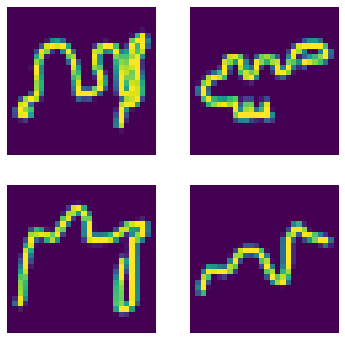

In [14]:
dataloaders.show_batch(max_n=4)

In [15]:
learner = GANLearner(dataloaders=dataloaders,
                     generator=generator,
                     critic=critic,
                     genr8r_loss_func=genr8r_loss_func,
                     critic_loss_func=critic_loss_func,
                     opt_func=RMSProp
                    )

# Since the validation loss is the same as the generator loss, don't display it
learner.recorder.train_metrics = True
learner.recorder.valid_metrics = False

In [16]:
learner.fit(40, 2e-4)

epoch,train_loss,genr8r_loss,critic_loss,time
0,1.033648,0.769714,1.351841,00:24
1,1.048925,0.740495,1.349261,00:24
2,1.043118,0.723694,1.362054,00:24
3,1.046916,0.718210,1.369226,00:24
4,1.047411,0.717146,1.369599,00:24
5,1.046701,0.716184,1.370575,00:24
6,1.047554,0.717587,1.368857,00:24
7,1.043491,0.715324,1.369567,00:24
8,1.043407,0.715801,1.368533,00:24
9,1.042383,0.711998,1.367485,00:23


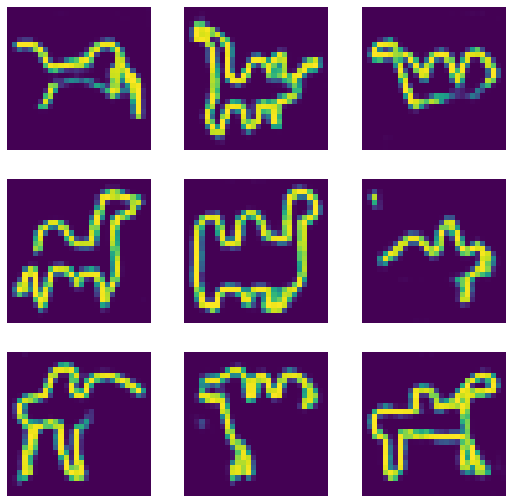

In [17]:
learner.show_results(max_n=9, ds_idx=0)